# Setup

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import glob
import re
from joblib import Parallel, delayed
from functools import partial
import scipy.sparse
import seaborn as sns
# import scanpy_gpu_funcs as rsf
# import cudf
# import cupy as cp
# from cuml.decomposition import PCA
from scipy.sparse import issparse
# from SCTransform import SCTransform
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
from matplotlib import rcParams
sc.set_figure_params(dpi= 100, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

from sklearn.neighbors import LocalOutlierFactor

os.chdir('/active/paper/')

# Load full adata

In [24]:
with open('input/adata/midbrain/adata_labelled_20220412.pickle', 'rb') as f:
    adata = pickle.load(f)
    
adata

AnnData object with n_obs × n_vars = 253055 × 19240
    obs: 'x', 'y', 'sample_id', 'mouse_id', 'age', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch', 'n_genes', 'total_counts_Malat1', 'log1p_total_counts_Malat1', 'pct_counts_Malat1', 'x_orig', 'y_orig', 'current_leiden', 'cell_type', 'comparison'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'level_1', 'cell_type_colors'
    obsm: 'spatial'

# Set seed

In [25]:
import random

def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(12)

### remove Plp1/Snap25/dopaminergic conflict cell types

In [26]:
plp1_snap25_dopa_conflict_cell_types = ["Dopaminergic_Higher-Complexity_Plp1+",
                                        "Plp1_Erythroid_Snap25+",
                                        "Snap25_Central_Plp1+",
                                        "Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_General_Plp1+++",
                                        "Plp1_Astrocyte-like_Ageing_Astrocytes_General_General_Snap25+",
                                        "Plp1_Plp1+++_Olig-Neurons",
                                        "Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_Astrocyte-associated"
                                        ]

In [27]:
adata = adata[~adata.obs['cell_type'].isin(plp1_snap25_dopa_conflict_cell_types)].copy()
adata

AnnData object with n_obs × n_vars = 231503 × 19240
    obs: 'x', 'y', 'sample_id', 'mouse_id', 'age', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch', 'n_genes', 'total_counts_Malat1', 'log1p_total_counts_Malat1', 'pct_counts_Malat1', 'x_orig', 'y_orig', 'current_leiden', 'cell_type', 'comparison'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'level_1', 'cell_type_colors'
    obsm: 'spatial'

### Functions to assess cell types

In [28]:
def test_cell_type_degs(adata, cols, cell_type_of_interest):
    adata_internal = adata[adata.obs['cell_type'].isin(cols)].copy()
    sc.pp.normalize_per_cell(adata_internal, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_internal)
    sc.tl.rank_genes_groups(adata_internal, 'cell_type', method='wilcoxon', key_added = "cell_type")
    df = sc.get.rank_genes_groups_df(adata_internal, key="cell_type", group = cell_type_of_interest)
    df = df.loc[df['pvals_adj'] < 0.001].copy()
    return(df)

def test_cell_type_degs_against_everything_else(adata, cell_type_of_interest):
    adata_internal = adata.copy()
    adata_internal.obs['cell_type_comparison'] = 'other'
    adata_internal.obs.loc[adata_internal.obs['cell_type'] == cell_type_of_interest, 'cell_type_comparison'] = cell_type_of_interest
    
    sc.pp.normalize_per_cell(adata_internal, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_internal)
    sc.tl.rank_genes_groups(adata_internal, 'cell_type', method='wilcoxon', key_added = "cell_type")
    df = sc.get.rank_genes_groups_df(adata_internal, key="cell_type", group = cell_type_of_interest)
    df = df.loc[df['pvals_adj'] < 0.001].copy()
    return(df)

def compare_complexity(adata, cols):
    adata_internal = adata[adata.obs['cell_type'].isin(cols)].copy()
    sns.set_theme(style="whitegrid")
    sns.violinplot(y = adata_internal.obs['cell_type'], 
                   x = adata_internal.obs['n_genes_by_counts'], 
                  scale='width', 
                  palette='pastel')
    
def plot_spatial_cell_types(adata, cols):
    adata_internal = adata[adata.obs['cell_type'].isin(cols)].copy()
    fig, axs = plt.subplots(nrows=adata_internal.obs['cell_type'].unique().shape[0], ncols=7, figsize=(35, 15))
    for row, cluster in enumerate(adata_internal.obs['cell_type'].unique()):
        for col, section in enumerate(adata_internal.obs.sample_id.unique()):
            sc.pl.spatial(adata_internal[adata_internal.obs['sample_id'] == section].copy(), 
                         spot_size=25, 
                          size = 5,
                          groups = cluster,
                         color = 'cell_type', 
                         ax=axs[row, col], 
                  palette='tab20',                          
                         show=False)
            ax.set_title(section)
            
def plot_gene_expression_cell_types(adata, cols, gene):
    adata_internal = adata[adata.obs['cell_type'].isin(cols)].copy()
    adata_internal.obs[gene] = adata_internal.X.A[:, adata_internal.var_names == gene]
    sns.set_theme(style="whitegrid")
    sns.violinplot(y = adata_internal.obs['cell_type'], 
                   x = adata_internal.obs[gene], 
                  scale='width', 
                  palette='pastel')

### Create more decisive cell_type label

In [29]:
adata.obs['cell_type_publish'] = adata.obs['cell_type'].copy()
# DA
adata.obs.loc[adata.obs['cell_type'].isin(['Dopaminergic_Higher-Complexity_Plp1-_Malat1+_SN', 'Dopaminergic_Higher-Complexity_Plp1-_Malat1-_SN']), 'cell_type_publish'] = "DA_SN"
adata.obs.loc[adata.obs['cell_type'].isin(['Dopaminergic_Higher-Complexity_Plp1-_Malat1+_VTA', 'Dopaminergic_Higher-Complexity_Plp1-_Malat1-_VTA']), 'cell_type_publish'] = "DA_VTA"
adata = adata[adata.obs['cell_type_publish'] != "Dopaminergic_Lower-Complexity", :].copy()
# Cartpt
# test_cell_type_degs(adata, ['Cartpt neurons (Edinger-Westphal nucleus)', 'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_Cartpt'], 'Cartpt neurons (Edinger-Westphal nucleus)')
# compare_complexity(adata, ['Cartpt neurons (Edinger-Westphal nucleus)', 'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_Cartpt'])
# plot_spatial_cell_types(adata, ['Cartpt neurons (Edinger-Westphal nucleus)', 'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_Cartpt'])
# plot_gene_expression_cell_types(adata, ['Cartpt neurons (Edinger-Westphal nucleus)', 'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_Cartpt'], gene="Cartpt")
# plot_gene_expression_cell_types(adata, ['Cartpt neurons (Edinger-Westphal nucleus)', 'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_Cartpt'], gene="Ucn")
adata.obs.loc[adata.obs['cell_type'].isin(['Cartpt neurons (Edinger-Westphal nucleus)']), 'cell_type_publish'] = "CARTPT++_EW"
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_Cartpt']), 'cell_type_publish'] = "CARTPT_EW_MB"
# Red blood cells
adata.obs.loc[adata.obs['cell_type'].isin(['Plp1_Erythroid_Erythroid']), 'cell_type_publish'] = "RBC"
# Thalamic neurons
# plot_spatial_cell_types(adata, ['Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_General_Sample-Dependent-1_Sample-Dependent-1_Thalamic-PAG',
#                                 'Snap25_Thalamic'])
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Thalamic']), 'cell_type_publish'] = "THALAMIC_DORSOLAT_NEU"
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_General_Sample-Dependent-1_Sample-Dependent-1_Thalamic-PAG']), 'cell_type_publish'] = "THALAMIC_VENTROMED_NEU"
# GABAergic Sst-Npy
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_GABAergic-Sst-Npy']), 'cell_type_publish'] = "GABA_SST_NPY"
# CA3 neurons
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields-CA3']), 'cell_type_publish'] = "CA3_NEU"
# CA1 neurons
# plot_spatial_cell_types(adata, ['Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_CA1_Sample-Consistent', 
#                                 'Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_CA1_Sample-Dependent'])
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_CA1_Sample-Consistent', 
                                'Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_CA1_Sample-Dependent']), 'cell_type_publish'] = "CA1_NEU"
# Dorsal subiculum
# plot_spatial_cell_types(adata, ['Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_Dorsal-Subiculum', 
#                                 'Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_Ventral-Subiculum-Sample-Dependent'])
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_Dorsal-Subiculum']), 
              'cell_type_publish'] = "SUBIC_DORSAL_NEU"
# Ventral subiculum-CA1 transition
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_Ventral-Subiculum-Sample-Dependent']), 
              'cell_type_publish'] = "SUBIC_VENTRAL_CA1_NEU"
# Dentate gyrus
# plot_spatial_cell_types(adata, ['Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_Dorsal-Subiculum', 
#                                 'Snap25_Cortical_Higher-Complexity_Hippocampus_DG-Prox1+', 
#                                 'Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_Lsamp+-Rbfox1+', 
#                                'Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_Whole-Brain-DCC+'])
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Hippocampus_DG-Prox1+']), 
              'cell_type_publish'] = "DG_NEU"
# DCC+ Hippocampal/Cortical neurons
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_Whole-Brain-DCC+']), 
              'cell_type_publish'] = "DCC_HIPP_CORT_NEU"
# Limbic/Cortical Lsamp/Rbfox1+ neurons
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Hippocampus_CA-Fields_CA1-Subiculum-Amygdala_General_Lsamp+-Rbfox1+']), 
              'cell_type_publish'] = "LIMBIC_CORT_LSAMP_RBFOX1_NEU"
# Cortical GABAergic neurons
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Central_Plp1-_Cortical']), 
              'cell_type_publish'] = "CORT_GABA_NEU"
# Nigral and RN Pvalb GABAergic neurons
# plot_spatial_cell_types(adata, ['Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_Pvalb+_Inner', 
#                                'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_Pvalb+_Outer-Sncg+', 
#                                'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Lower-Complexity'])
# plot_gene_expression_cell_types(adata, ['Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_Pvalb+_Inner',
#                                 'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_Pvalb+_Outer-Sncg+',
#                                 'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_General_Sample-Dependent-2_Pvalb+', 
                                    # 'Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_General_General_Ventral-Pvalb+'], 
#                                'Gad2')
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_Pvalb+_Inner', 
                                           'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_General_Sample-Dependent-2_Pvalb+', 
                                          'Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_General_General_Ventral-Pvalb+']), 
              'cell_type_publish'] = "NIGRAL_RN_PVALB_GABA_NEU"
# RN Pvalb Sncg neurons (not GABAergic)
# test_cell_type_degs(adata, ['Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_Pvalb+_Inner', 
#                                'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_Pvalb+_Outer-Sncg+'], 'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_Pvalb+_Outer-Sncg+')
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_Pvalb+_Outer-Sncg+']), 
              'cell_type_publish'] = "RN_PVALB_SNCG_NEU"
# General Midbrain Neurons
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_General_Sample-Dependent-1_Sample-Dependent-1_General_Dorsal', 
                               'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_General_Sample-Dependent-1_Sample-Dependent-1_General_General', 
                                'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_General_Sample-Dependent-1_Sample-Dependent-2', 
                               'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_General_Sample-Dependent-2_Ahi+', 
                                          'Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_General_General_General_General_General_General_Malat1+', 
                                           'Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_General_General_General_General_General_General_Malat1-_Sample-Dependent-1',
                                           'Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_General_General_General_General_General_General_Malat1-_Sample-Dependent-2',
                                           'Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_General_General_General_General', 
                                           'Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_Cntn5+', 
                                           'Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_General_General_General_Cntnap2+', 
                                           'Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Lower-Complexity'
                                          ]), 
              'cell_type_publish'] = "GENERAL_MB_NEU"
# Cortical excitatory neurons: Outer
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Outer-Cortex_General_General']), 
              'cell_type_publish'] = "CORTICAL_OUTER_EXCIT_NEU"
# Cortical excitatory neurons: Inner
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Inner-Cortex']), 
              'cell_type_publish'] = "CORTICAL_INNER_EXCIT_NEU"
# Cortical excitatory neurons: Dorsomedial
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Outer-Cortex_General_Dorsomedial']), 
              'cell_type_publish'] = "CORTICAL_DORSOMED_EXCIT_NEU"
# Cortical excitatory neurons: Ventrolateral
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Higher-Complexity_Outer-Cortex_Ventral']), 
              'cell_type_publish'] = "CORTICAL_VENTROLAT_EXCIT_NEU"
# Superior Colliculus GABAergic
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_General_General_General_SupColl-GABAergic']), 
              'cell_type_publish'] = "SUPCOL_GABA_NEU"
# Kainate receptor positive Neurons
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Central_Plp1-_Mbp-Plp+_Malat1+_General_General_General_General_General_General_Grik1+++']), 
              'cell_type_publish'] = "KAINATE_NEU"
# Pontine
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Central_Plp1-_PontineGray/MCP']), 
              'cell_type_publish'] = "PONTINE_NEU"
# CGRP neurons
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Central_Plp1-_Mbp-Plp+_Malat1-_General_Higher-Complexity_General_Calca+']), 
              'cell_type_publish'] = "PONTINE_NEU"
# Cortical and Thalamic Il31ra-associated neurons
adata.obs.loc[adata.obs['cell_type'].isin(['Snap25_Cortical_Camk1d-Il31ra']), 
              'cell_type_publish'] = "CORTICAL_THALAMIC_IL31RA_NEU"
# Meningeal glia
adata.obs.loc[adata.obs['cell_type'].isin(['Plp1_Astrocyte-like_Ageing-Dura-Mater',
                                           'Plp1_Astrocyte-like_Ageing-Astrocytes_Dura-Mater', 
                                           'Plp1_Astrocyte-like_Ageing_Astrocytes_General_Dura-Mater']), 
              'cell_type_publish'] = "MENINGEAL_GLIA"

# Ageing Astrocytes: Mt3, Atp1a2, Slc1a3, Gfap
adata.obs.loc[adata.obs['cell_type'].isin(['Plp1_Astrocyte-like_Cathepsin-Tyrobp_Higher-Complexity-Plp1+', 
                                          'Plp1_Astrocyte-like_Ageing_Astrocytes_General_General_Lower-Complexity']), 
              'cell_type_publish'] = "AGE_ASTRO"

# Oligodendrocytes: Sox10, Mog, Mbp, Olig1
adata.obs.loc[adata.obs['cell_type'].isin(['Plp1_Plp1+++_Cathepsin-Tyrobp', 
                                          'Plp1_Astrocyte-like_Ageing_Astrocytes_General_General_Oligodendrocytes', 
                                          'Plp1_Plp1+++_Lower-Complexity_Ageing']), 
              'cell_type_publish'] = "AGE_OLIG"

# Microglia: Tyrobp, Ftl1, Cts*, Aif1, Tmem119, Cd68
adata.obs.loc[adata.obs['cell_type'].isin(['Plp1_Astrocyte-like_Cathepsin-Tyrobp_Lower-Complexity']), 
              'cell_type_publish'] = "AGE_MICRO"

# Age-independent oligodendrocytes
adata.obs.loc[adata.obs['cell_type'].isin(['Plp1_Plp1+++_Lower-Complexity_Non-Ageing']), 
              'cell_type_publish'] = "OLIG"

Glial discernment code (finished in R)

In [30]:
# adata_discern_glia = adata[adata.obs['cell_type'].isin(['Plp1_Astrocyte-like_Ageing_Astrocytes_General_General_Lower-Complexity', 
#                              'Plp1_Plp1+++_Lower-Complexity_Ageing',
#                              'Plp1_Astrocyte-like_Ageing_Astrocytes_General_General_Oligodendrocytes']), :].copy()

# del adata_discern_glia.uns['log1p']
# sc.pp.normalize_total(adata_discern_glia, target_sum=1e4)
# sc.pp.log1p(adata_discern_glia)

# GOI = 'Plp1'

# adata_discern_glia.obs['GOI_count'] = adata_discern_glia.X[:, adata_discern_glia.var_names == GOI].A.flatten().tolist()

# adata_discern_glia.obs.groupby('cell_type')['GOI_count'].median()

# adata_discern_glia.obs['GOI_detected'] = adata_discern_glia.obs['GOI_count'] > 0
# adata_discern_glia.obs.groupby('cell_type')['GOI_detected'].mean()

# sc.tl.rank_genes_groups(adata_discern_glia, 
#                         groupby='cell_type', 
#                         method='wilcoxon', 
#                         key_added='markers', 
#                         pts=True)

# for cell_type in adata_discern_glia.obs['cell_type_simpler'].unique():
#     print(cell_type)
#     df = sc.get.rank_genes_groups_df(adata_discern_glia, key='markers', group=cell_type)
#     df = df.loc[df['pvals_adj'] < 0.001]
#     df.to_csv('output/markers/glial_discernment/'+cell_type+'.csv', index=False)

In [31]:
adata.obs.groupby('cell_type_publish').size()

cell_type_publish
AGE_ASTRO                                   13324
AGE_MICRO                                    2664
AGE_OLIG                                    11885
CA1_NEU                                      7331
CA3_NEU                                      1746
CARTPT++_EW                                   153
CARTPT_EW_MB                                  221
CORTICAL_DORSOMED_EXCIT_NEU                  3039
CORTICAL_INNER_EXCIT_NEU                    19079
CORTICAL_OUTER_EXCIT_NEU                    33906
CORTICAL_THALAMIC_IL31RA_NEU                 1402
CORTICAL_VENTROLAT_EXCIT_NEU                 7448
CORT_GABA_NEU                                9077
DA_SN                                        1306
DA_VTA                                       1026
DCC_HIPP_CORT_NEU                             246
DG_NEU                                        873
GABA_SST_NPY                                 8116
GENERAL_MB_NEU                              32901
KAINATE_NEU                     

### cell types with < 600 genes median

In [32]:
low_complexity_cell_types = adata.obs.groupby('cell_type_publish')['n_genes_by_counts'].median().loc[adata.obs.groupby('cell_type_publish')['n_genes_by_counts'].median() < 600].index.tolist()
low_complexity_cell_types

['AGE_ASTRO',
 'AGE_MICRO',
 'AGE_OLIG',
 'KAINATE_NEU',
 'MENINGEAL_GLIA',
 'OLIG',
 'RBC',
 'Snap25_Cortical_Lower-Complexity_General',
 'Snap25_Cortical_Lower-Complexity_Ventral',
 'THALAMIC_DORSOLAT_NEU']

Remove RBC, as they could be small

In [33]:
# low_complexity_cell_types = [cell_type for cell_type in low_complexity_cell_types if cell_type != 'RBC']

Add low complexity metadata

In [34]:
adata.obs['low_complexity'] = adata.obs['cell_type_publish'].isin(low_complexity_cell_types)

In [35]:
low_complexity_cell_types

['AGE_ASTRO',
 'AGE_MICRO',
 'AGE_OLIG',
 'KAINATE_NEU',
 'MENINGEAL_GLIA',
 'OLIG',
 'RBC',
 'Snap25_Cortical_Lower-Complexity_General',
 'Snap25_Cortical_Lower-Complexity_Ventral',
 'THALAMIC_DORSOLAT_NEU']

/home/peter/miniconda3/envs/paper_stage4/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/peter/miniconda3/envs/paper_stage4/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/peter/miniconda3/envs/paper_stage4/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/peter/miniconda3/envs/paper_stage4/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/peter/

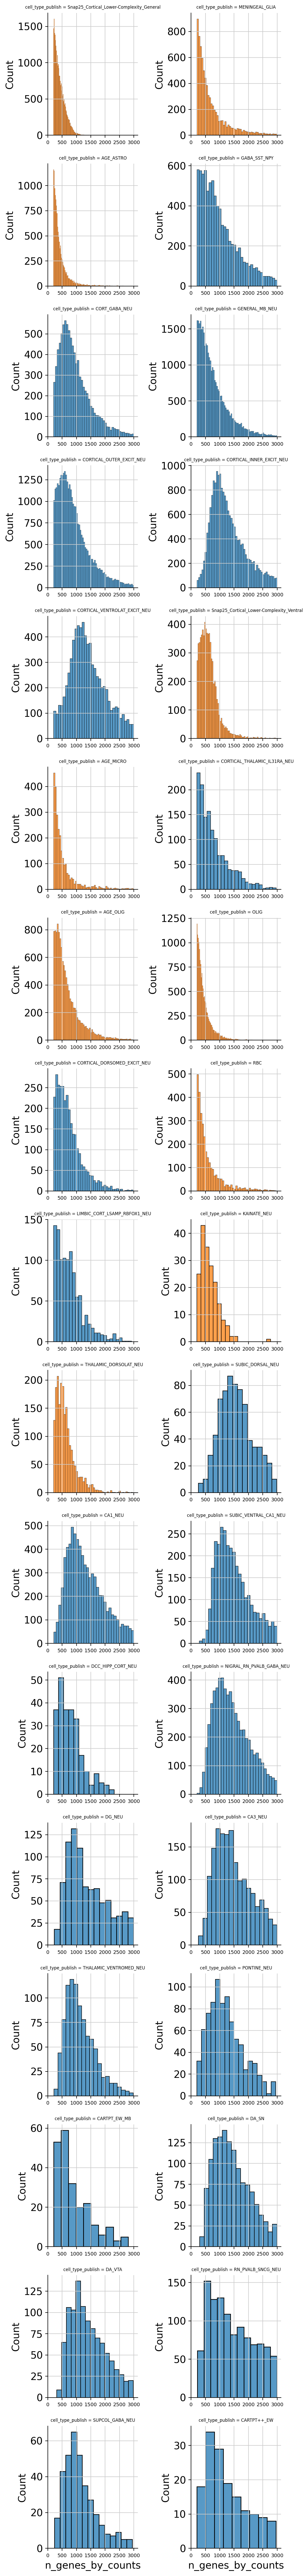

In [36]:
g = sns.FacetGrid(adata.obs, hue = 'low_complexity', col="cell_type_publish", col_wrap=2, sharey=False)
g.map(sns.histplot, "n_genes_by_counts")

for ax in g.axes.flatten():
    g.set_titles(size=6)
    ax.set_xticks(np.arange(0, 3500, 500))
    ax.set_xticklabels(['0', '500', '1000', '1500', '2000', '2500', '3000'], fontsize=7)
    ax.tick_params(labelbottom=True)

### remove low complexity cell types

In [37]:
adata = adata[~adata.obs['cell_type'].isin(['Snap25_Cortical_Lower-Complexity_General', 'Snap25_Cortical_Lower-Complexity_Ventral'])].copy()
adata

AnnData object with n_obs × n_vars = 197698 × 19240
    obs: 'x', 'y', 'sample_id', 'mouse_id', 'age', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch', 'n_genes', 'total_counts_Malat1', 'log1p_total_counts_Malat1', 'pct_counts_Malat1', 'x_orig', 'y_orig', 'current_leiden', 'cell_type', 'comparison', 'cell_type_publish', 'low_complexity'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'level_1', 'cell_type_colors'
    obsm: 'spatial'

# Save adata

In [16]:
with open('input/adata/midbrain/adata_final_label.pickle', 'wb') as f:
    pickle.dump(adata, f)

### Export UMAP coords

In [16]:
adata_temp = adata.copy()
sc.pp.normalize_total(adata_temp, target_sum=1e4)
sc.pp.log1p(adata_temp)
sc.pp.highly_variable_genes(adata_temp, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_temp = adata_temp[:, adata_temp.var.highly_variable]
sc.pp.scale(adata_temp, max_value=10)
sc.tl.pca(adata_temp, svd_solver='arpack')
sc.pp.neighbors(adata_temp, n_neighbors=20, n_pcs=40)
# sc.tl.paga(adata_temp)
# sc.pl.paga(adata_temp, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(adata_temp)


/home/peter/miniconda3/envs/paper-gpu/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
sc.tl.umap(adata_temp, min_dist=0.1, spread=5)
# sc.pl.umap(adata_temp)

/home/peter/miniconda3/envs/paper-gpu/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [18]:
adata_temp.obs['neu_glia'] = 'NEURONAL'
adata_temp.obs.loc[adata_temp.obs['cell_type_publish'].str.contains('GLIA|OLIG|RBC|MICRO|ASTRO'), 'neu_glia'] = 'GLIAL'

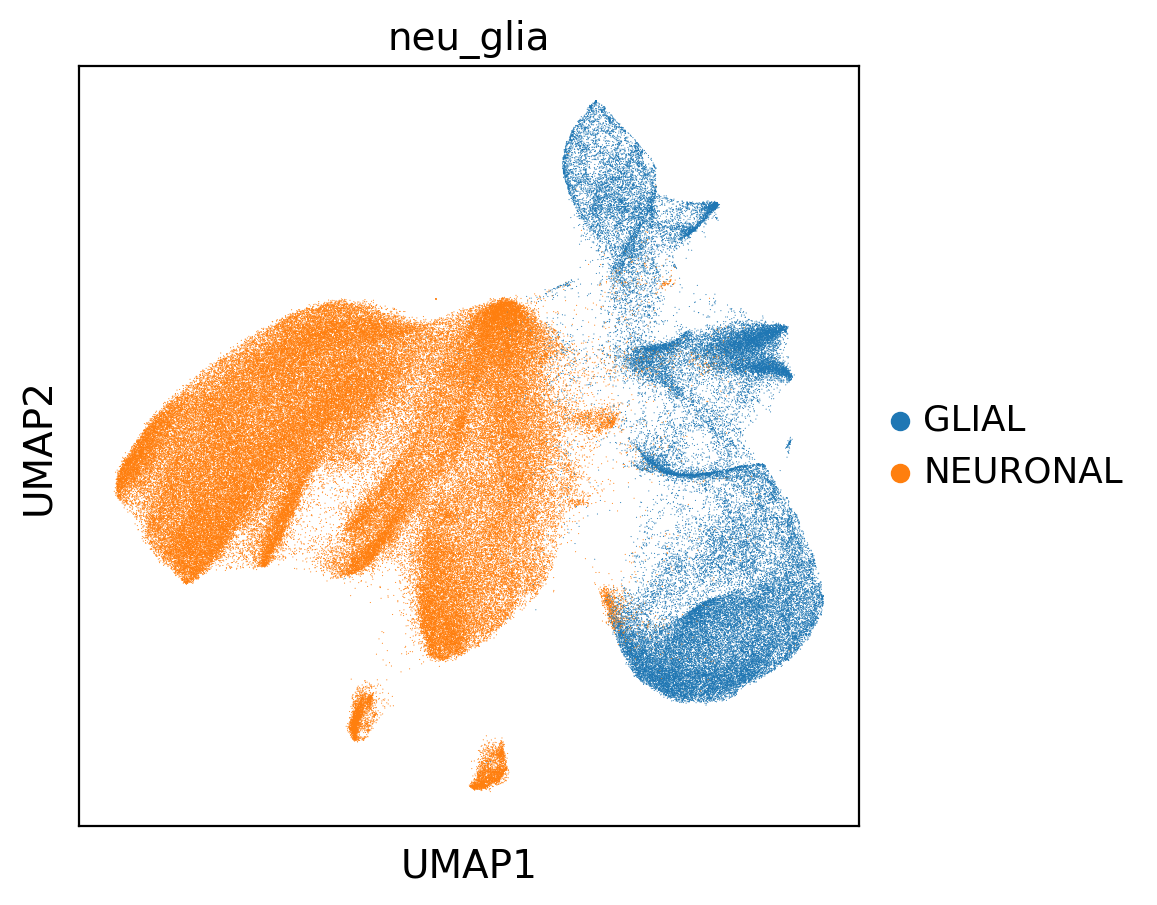

In [19]:
sc.pl.umap(adata_temp, color = 'neu_glia')

### Save UMAP coordinates of all cells for Fig 1

In [20]:
pd.DataFrame(adata_temp.obsm['X_umap'], index=adata_temp.obs.index, columns=['UMAP1', 'UMAP2']).merge(adata_temp.obs[['mouse_id', 'age', 'genotype', 'cell_type', 'cell_type_publish']], left_index=True, right_index=True).to_csv('output/UMAP/all_cells.csv')

### Save spatial coordinates of all cells for Fig 1

In [21]:
adata_temp.obs[['mouse_id', 'age', 'genotype', 'cell_type', 'cell_type_publish', 'x', 'y']].to_csv('output/spatial_coordinates/all_cells.csv')

### Export counts for MAST DE testing in R

In [22]:
import scipy.io as sio
sio.mmwrite('output/counts/adata.mtx', adata.X)

### Export gene names for MAST DE testing in R

In [23]:
pd.DataFrame(adata.var_names).to_csv('output/counts/var_names.csv', index=False)

### Get list of glial markers 

In [24]:
adata_marker = adata.copy()
adata_marker.obs['neu_glia'] = 'NEURONAL'
adata_marker.obs.loc[adata_marker.obs['cell_type_publish'].str.contains('GLIA|RBC|ASTRO|MICRO|OLIG'), 'neu_glia'] = 'GLIAL'
sc.pp.normalize_per_cell(adata_marker, counts_per_cell_after=1e4)
sc.pp.log1p(adata_marker)
sc.tl.rank_genes_groups(adata_marker, 'neu_glia', method='wilcoxon', key_added = 'neu_glia')
markers_glial_wilcoxon = sc.get.rank_genes_groups_df(adata_marker, key='neu_glia', group='GLIAL')

In [25]:
markers_glial_wilcoxon.to_csv('output/markers/GLIAL.csv')

### Get markers of each cell type

In [ ]:
# adata.obs['cell_type_publish'].unique()
adata_marker = adata.copy()
sc.pp.normalize_per_cell(adata_marker, counts_per_cell_after=1e4)
sc.pp.log1p(adata_marker)
sc.tl.rank_genes_groups(adata_marker, 
                        groupby='cell_type_publish', 
                        # groups='all', 
                        # reference='rest', 
                        method='wilcoxon')
# markers_glial_wilcoxon = sc.get.rank_genes_groups_df(adata_marker, key='neu_glia', group='GLIAL')

In [32]:
markers = [sc.get.rank_genes_groups_df(adata_marker, key="rank_genes_groups", group = cell_type) for cell_type in adata_marker.obs['cell_type_publish'].unique()]
markers = dict(zip(list(adata_marker.obs['cell_type_publish'].unique()), markers))

In [33]:
for cell_type in markers.keys():
    markers[cell_type].to_csv('output/markers/general/'+cell_type+'.csv', index=False)

In [34]:
pd.DataFrame(adata_marker.uns['rank_genes_groups']['names']).head(5)

,AGE_ASTRO,AGE_MICRO,AGE_OLIG,CA1_NEU,CA3_NEU,CARTPT++_EW,CARTPT_EW_MB,CORTICAL_DORSOMED_EXCIT_NEU,CORTICAL_INNER_EXCIT_NEU,CORTICAL_OUTER_EXCIT_NEU,...,NIGRAL_RN_PVALB_GABA_NEU,OLIG,PONTINE_NEU,RBC,RN_PVALB_SNCG_NEU,SUBIC_DORSAL_NEU,SUBIC_VENTRAL_CA1_NEU,SUPCOL_GABA_NEU,THALAMIC_DORSOLAT_NEU,THALAMIC_VENTROMED_NEU
0,Apoe,Apoe,Plp1,Tmsb4x,Hpca,Cartpt,Cartpt,Gm28928,Nrgn,Celf2,...,Pvalb,Plp1,Spp1,Hbb-bs,Nefm,Kcnip4,Tmsb4x,Gad1,Camk1d,Calb2
1,Malat1,Ctsd,Fth1,Crym,Snca,Ucn,Nap1l5,Adgrb3,Calm2,Malat1,...,Nefm,Fth1,Pcp4,Hba-a1,Nefl,Etv1,Snca,Gad2,Il31ra,Nap1l5
2,Cst3,Cst3,Trf,Nrgn,Cpne6,Cck,Calb2,Kcnq5,Pcp4,Kcnip4,...,Ldhb,Trf,Snap25,Hba-a2,Pvalb,Grm5,Nnat,Trpm3,Gphn,6330403K07Rik
3,Mt1,C1qa,Mbp,Snca,Cck,Sncg,Rps8,Dpp10,Snap25,Meg3,...,Cplx1,Mbp,Map1b,Hbb-bt,Nefh,Nrgn,Dynll1,Pcbp3,Lars2,Tcf7l2
4,Slc1a2,Tyrobp,Apod,Hpca,Nrgn,Gap43,Rplp1,Rims1,Calm1,Ptprd,...,Vamp1,Cryab,Calb2,Ptgds,Cplx1,Gria1,Calm2,Cntnap2,Gm26561,Gap43


### Get markers of DA neurons (SN + VTA)

In [16]:
adata_marker = adata.copy()
adata_marker.obs.loc[adata_marker.obs['cell_type_publish'].isin(['DA_SN', 'DA_VTA']), 'cell_type_publish'] = 'DA'
sc.pp.normalize_per_cell(adata_marker, counts_per_cell_after=1e4)
sc.pp.log1p(adata_marker)
sc.tl.rank_genes_groups(adata_marker, 
                        groupby='cell_type_publish', 
                        groups=['DA'], 
                        reference='rest', 
                        method='wilcoxon')

In [17]:
sc.get.rank_genes_groups_df(adata_marker, key="rank_genes_groups", group = 'DA').to_csv('output/markers/da_markers.csv')

In [18]:
del adata_marker

# Get markers of SN and VTA

In [42]:
adata_marker = adata.copy()
adata_marker = adata_marker[adata_marker.obs['cell_type_publish'].isin(['DA_SN', 'DA_VTA']), :]
sc.pp.normalize_per_cell(adata_marker, counts_per_cell_after=1e4)
sc.pp.log1p(adata_marker)
sc.tl.rank_genes_groups(adata_marker, 
                        groupby='cell_type_publish', 
                        reference='rest', 
                        method='wilcoxon')

/home/peter/miniconda3/envs/paper_stage4/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [45]:
sc.get.rank_genes_groups_df(adata_marker, key="rank_genes_groups", group = 'DA_SN').to_csv('output/markers/sn_vta_markers.csv')

## DA Spatial Genes


Export individual h5 file for each section of DA neurons

In [22]:
adata_DA = adata.copy()
adata_DA = adata_DA[adata_DA.obs['cell_type_publish'].isin(['DA_SN', 'DA_VTA']), :]
for section in adata_DA.obs['mouse_id'].unique():
    adata_DA[adata_DA.obs['mouse_id'] == section, :].write("output/spatial_genes/"+section+".h5")

/home/peter/miniconda3/envs/paper_stage4/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


Refer to spatialDE2.ipynb for remainder of code (separate env)

## Export per section counts of every other cell type for SpatialDE analysis

In [40]:
path = "output/spatial_genes/h5"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)

for ct in adata.obs['cell_type_publish'].unique().tolist():
    # print(ct)
    adata_ct = adata[adata.obs['cell_type_publish'] == ct, :].copy()
    print("Before: " + str(adata_ct.shape))
    sc.pp.filter_genes(adata_ct, min_cells=adata_ct.shape[0]*0.15) # only consider genes expressed in at least 15 % of cells
    print("After: " + str(adata_ct.shape))
    for section in adata_ct.obs['mouse_id'].unique().tolist():
        # print(section)
        adata_ct[adata_ct.obs['mouse_id'] == section, :].write(path+'/'+ct+'_'+section+'.h5')

Before: (7421, 19240)
After: (7421, 809)


/home/peter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


Before: (13324, 19240)
After: (13324, 399)
Before: (8116, 19240)
After: (8116, 1660)
Before: (9077, 19240)
After: (9077, 1502)
Before: (32901, 19240)
After: (32901, 1116)
Before: (33906, 19240)
After: (33906, 1416)
Before: (19079, 19240)
After: (19079, 2342)
Before: (7448, 19240)
After: (7448, 2623)
Before: (2664, 19240)
After: (2664, 621)
Before: (1402, 19240)
After: (1402, 1223)
Before: (11885, 19240)
After: (11885, 908)
Before: (14964, 19240)
After: (14964, 519)
Before: (3039, 19240)
After: (3039, 1121)
Before: (3067, 19240)
After: (3067, 687)
Before: (1053, 19240)
After: (1053, 1130)
Before: (186, 19240)
After: (186, 876)
Before: (2000, 19240)
After: (2000, 817)
Before: (712, 19240)
After: (712, 3164)
Before: (7331, 19240)
After: (7331, 2470)
Before: (3165, 19240)
After: (3165, 2805)
Before: (246, 19240)
After: (246, 1228)
Before: (6168, 19240)
After: (6168, 2653)
Before: (873, 19240)
After: (873, 2675)
Before: (1746, 19240)
After: (1746, 2868)
Before: (933, 19240)
After: (933, 198

## Export DA counts of spatial genes

In [40]:
spatialDE2_results = pd.read_csv('output/spatial_genes/results.csv')
adata_DA_spatial_100 = adata_DA[:, adata_DA.var_names.isin(list(spatialDE2_results.sort_values('p').head(100)['gene']))].copy()
pd.DataFrame(adata_DA_spatial_100.X.A, columns=adata_DA_spatial_100.var_names, index = adata_DA_spatial_100.obs_names).to_csv('output/spatial_genes/da_spatial_counts_top_100.csv')
adata_DA_spatial_100.obs.to_csv('output/spatial_genes/da_spatial_counts_top_100_meta.csv')

## Macosko Mouse DA data

In [87]:
adata_macosko = sc.read_10x_mtx('input/third_party_data/mousedata_todistribute/')
adata_macosko.obs = pd.read_csv('input/third_party_data/mousedata_todistribute/mousecelldata.tsv', sep = '\t', 
           names=['cell_id', 'nUMI', 'nGene', 'dataset', 'humanannots', 'primate', 'clusters'], 
           skiprows=1).set_index('cell_id')
sc.pp.filter_genes(adata_DA, min_cells=30)
adata_macosko

AnnData object with n_obs × n_vars = 1279 × 21598
    obs: 'nUMI', 'nGene', 'dataset', 'humanannots', 'primate', 'clusters'
    var: 'gene_ids'

### Make DA subset

In [72]:
adata_DA = adata[adata.obs['cell_type_publish'].str.contains('DA_SN|DA_VTA')].copy()
# sc.pp.filter_genes(adata_DA, min_cells=20)
adata_DA

AnnData object with n_obs × n_vars = 2332 × 19240
    obs: 'x', 'y', 'sample_id', 'mouse_id', 'age', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch', 'n_genes', 'total_counts_Malat1', 'log1p_total_counts_Malat1', 'pct_counts_Malat1', 'x_orig', 'y_orig', 'current_leiden', 'cell_type', 'comparison', 'cell_type_publish', 'low_complexity'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'level_1', 'cell_type_colors'
    obsm: 'spatial'

In [74]:
var_names = adata_macosko.var_names.intersection(adata_DA.var_names)
adata_macosko = adata_macosko[:, var_names]
adata_DA = adata_DA[:, var_names]

In [75]:
sc.pp.pca(adata_macosko)
sc.pp.neighbors(adata_macosko)
sc.tl.umap(adata_macosko)

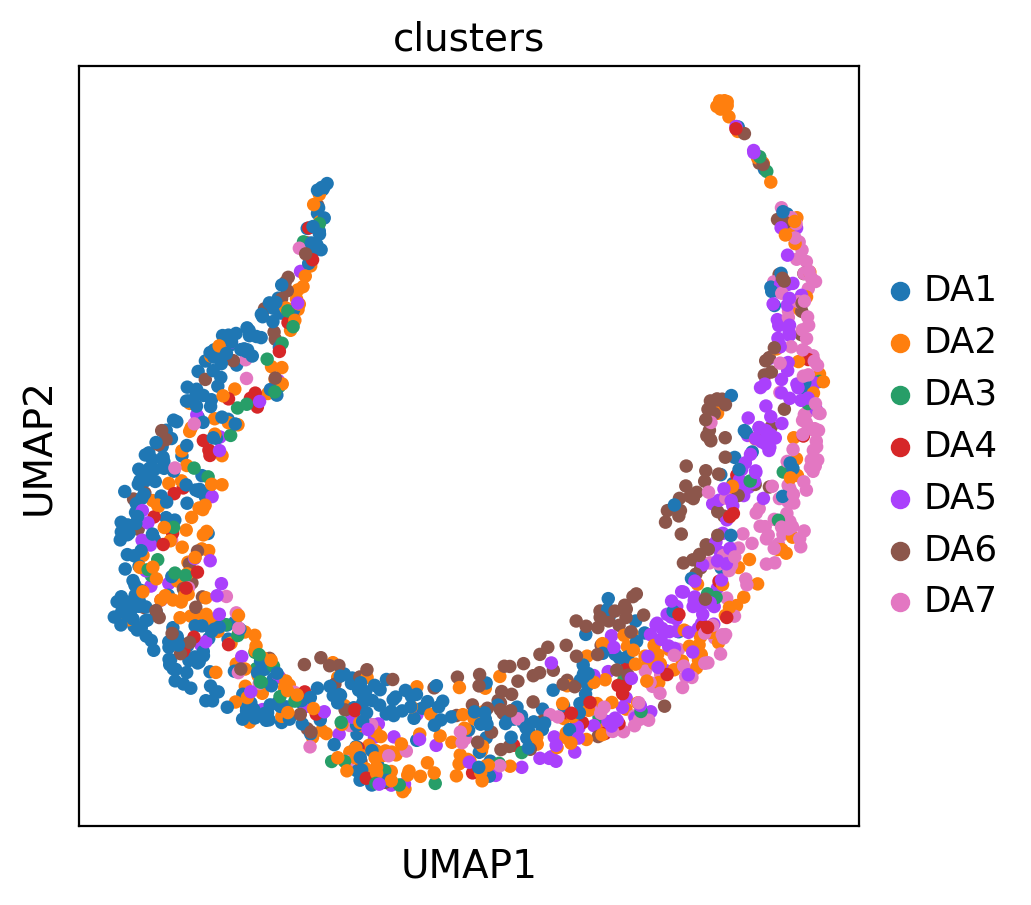

In [77]:
sc.pl.umap(adata_macosko, color='clusters')

In [78]:
sc.tl.ingest(adata_DA, adata_macosko, obs='clusters')

In [80]:
adata_macosko.uns['clusters_colors']

['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2']

In [ ]:
adata_DA.uns['clusters_colors']

In [85]:
adata_DA.obs.groupby(['cell_type_publish', 'clusters']).size()

cell_type_publish  clusters
DA_SN              DA1         463
                   DA2         843
                   DA3           0
                   DA4           0
                   DA5           0
                   DA6           0
                   DA7           0
DA_VTA             DA1         483
                   DA2         543
                   DA3           0
                   DA4           0
                   DA5           0
                   DA6           0
                   DA7           0
dtype: int64

### Export Casr Counts

In [118]:
# adata_DA = adata[adata.obs['cell_type_publish'].str.contains('DA_SN|DA_VTA')].copy()


counts_Casr = adata.X.A[:,adata.var_names == 'Casr'].flatten().tolist()

In [119]:
d = {}
d['cell_id'] = adata.obs_names.to_list()
d['cell_type_publish'] = adata.obs['cell_type_publish']
d['count_Casr'] = counts_Casr

In [121]:
pd.DataFrame(d).to_csv('output/counts/counts_casr.csv')